# MTMount accelerometers
MTMount accelerometers readings vs MTMount azimuth and elevation velocities from encoders. 

First, we will write some code for the MTMount accelerometers. After that, we will get the readings from the VMS accelerometers in HDF5 format from ssh vms-data.cp.lsst.org, and work on the code more. 

Things to do:
- Add top elevation axis accelerations vs AZ and EL
- FFTs and corr matrix. Think about rolling average and FFT frate. 
- More plots. 
- Add VMS data that Prakruth converted. 
- Get more ideas on what to do. 
- Convert X, Y and Z accelerations to AZ and EL accelerations using function below AccelerometerAccels() and plot again
-

In [222]:
import sys, time, os, asyncio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.time import Time, TimeDelta
from scipy.interpolate import UnivariateSpline

%matplotlib widget
import aioinflux
import getpass

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import LinearAxis, Range1d, Span, Label
# from bokeh.layouts import columns
output_notebook()

from lsst_efd_client import EfdClient, resample, merge_packed_time_series, rendezvous_dataframes

Loading BokehJS ...

In [5]:
# Get EFD client
client = EfdClient('summit_efd')

# Declare timestamps 

In [109]:
# Times to look at the data
start = Time("2023-03-25T01:26:45", scale='utc')
end = Time("2023-03-25T01:27:02", scale='utc')

## or 
# window = TimeDelta(300, format = 'sec')
# end = start + window

##  Functions for calculating the accelerations

In [179]:
baseFields = ['accelerationX', 'accelerationY', 'accelerationZ']
sensorNames = ['SST top end ring +x -y', 'SST top end ring -x -y', 'SST spider spindle', 'SST M2 surrogate'] 
colours = ['red', 'orange', 'blue', 'green']

def Locations(sensorName):
    # This carries the sensor location information
    if sensorName == 'SST top end ring +x -y':
        X = 3.876; Y = -3.696; Z = 4.65
    if sensorName == 'SST top end ring -x -y':
        X = -3.786; Y = -3.786; Z = 4.653
    if sensorName == 'SST spider spindle':
        X = -1.275; Y = 0.602; Z = 5.383
    if sensorName == 'SST M2 surrogate':
        X = -1.882; Y = 0.0; Z = 4.342
    r_theta = np.sqrt(Z**2 + Y**2)
    r_phi = np.sqrt(Z**2 + Y**2 + X**2)
    return [X, Y, Z, r_theta, r_phi]
    

def AccelerometerAccels(packed_dataframe, el, sensorName, start_slew, inPos):
    # This rotates the accelerometer accelerations into AzEl space
    g = 9.5
    rolling_average = 100 # Smooths the noisy data   
    sub_df = packed_dataframe.loc[packed_dataframe.sensorName==sensorName] 
    sub_df = sub_df[(sub_df['timestamp'] > (start_slew - 2.0)) & (sub_df['timestamp'] < (inPos + 1.0))]
    el = el[(el['timestamp'] > (start_slew - 2.0)) & (el['timestamp'] < (inPos + 1.0))]
    elevations = np.array(el.actualPosition[np.argmin(np.abs(np.subtract(np.array(el.timestamp), \
                                np.expand_dims(np.array(sub_df.timestamp), 0).T)), axis = 1)])
    unpacked_elevations = np.repeat(elevations, 200) * np.pi/180.0 # In radians
    [X, Y, Z, r_theta, r_phi] = Locations(sensorName) # Get the sensor coordinates
    r_phi_axis = np.sqrt((Z * np.cos(unpacked_elevations) \
                          - Y * np.sin(unpacked_elevations))**2 \
                          + X**2)
    for baseField in baseFields:
        df = merge_packed_time_series(sub_df, baseField, stride=1,
                             ref_timestamp_col="timestamp", fmt='unix_tai',
                             scale='tai')
        if baseField == 'accelerationX':
            az_el_accel_df = pd.DataFrame(data = {'AccelerationElevation': np.zeros(len(df.index)), \
                                                  'AccelerationAzimuth': np.zeros(len(df.index)), \
                                                  'times': df['times'] - df['times'].values[0]})
            az_el_accel_df['AccelerationAzimuth'] -= (np.array(df['accelerationX']) * (Z * np.cos(unpacked_elevations) \
                                                  - Y * np.sin(unpacked_elevations)) / (r_phi_axis**2)) * 180.0/np.pi
        if baseField == 'accelerationY':
            df['accelerationY'] -=  g * np.cos(unpacked_elevations)
            az_el_accel_df['AccelerationElevation'] += (np.array(df['accelerationY']) * Z / (r_theta**2)) * 180.0/np.pi
            az_el_accel_df['AccelerationAzimuth'] -= (np.array(df['accelerationY'])) * np.sin(unpacked_elevations) \
                                                        * (X / (r_phi_axis**2)) * 180.0/np.pi
        if baseField == 'accelerationZ':
            df['accelerationZ'] -=  g * np.sin(unpacked_elevations)
            az_el_accel_df['AccelerationElevation'] -= (np.array(df['accelerationZ']) * Y / (r_theta**2)) * 180.0/np.pi 
            az_el_accel_df['AccelerationAzimuth'] += (np.array(df['accelerationZ']) * np.cos(unpacked_elevations) \
                                                           * X / (r_phi_axis**2)) * 180.0/np.pi

    # Now subtract off the mean.  This shouldn't be necessary if we have successfully removed g
    az_el_accel_df['AccelerationAzimuth'] -= az_el_accel_df['AccelerationAzimuth'].mean()
    az_el_accel_df['AccelerationElevation'] -= az_el_accel_df['AccelerationElevation'].mean()
    # Now do a rolling average to smooth the data
    az_el_accel_df['AccelerationAzimuth'] = az_el_accel_df['AccelerationAzimuth'].rolling(rolling_average, center=True).sum() / rolling_average 
    az_el_accel_df['AccelerationElevation'] = az_el_accel_df['AccelerationElevation'].rolling(rolling_average, center=True).sum() / rolling_average
    return az_el_accel_df

In [180]:
def show_in_pos(dfPos):
    for slew in range(len(dfPos)):
        inPosition = Time(dfPos.index[slew], scale='utc')
        inPosition_vline = Span(location=inPosition.datetime64, dimension='height', line_color='olivedrab', line_width=0.9, line_dash='dashed')
        inPosition_label = Label(x=inPosition.datetime64, text = "Axis In Position")
        p.add_layout(inPosition_vline)
        p.add_layout(inPosition_label)
        
def show_track_command(dfTrack):
    for slew in range(len(dfTrack)):
        trackCommand = Time(dfTrack.index[slew], scale='utc')
        trackCommand_vline = Span(location=trackCommand.datetime64, dimension='height', line_color='magenta', line_width=0.5, line_dash='dashed')
        trackCommand_label = Label(x=trackCommand.datetime64, text = "CommandAxis")
        p.add_layout(trackCommand_vline)
        p.add_layout(trackCommand_label)

In [274]:
dataframe = pd.DataFrame()

def build_df_with_all_accelerometers(packed_df):
    for i, sensorName in enumerate(sensorNames):
        sub_dataframe = packed_dataframe.loc[packed_dataframe.sensorName==sensorName]
        for baseField in baseFields:
            df_basefield = merge_packed_time_series(sub_dataframe, baseField, stride=1,
                             ref_timestamp_col="timestamp", fmt='unix_tai',
                             scale='tai')
            # dataframe[f'{baseField}_sensor{i}_times'] = df_basefield['times']
            dataframe[f'{baseField[-1]}_sensor{i}'] = df_basefield.iloc[:,0]
            
    return dataframe      

##  Query EFD to get MTMount data for the selected times

In [112]:
packed_dataframe = await client.select_time_series("lsst.sal.ESS.accelerometer", ["*"], start, end)

az = await client.select_time_series('lsst.sal.MTMount.azimuth', \
                                        ['actualPosition', 'actualVelocity', 'timestamp'],  start, end)
el = await client.select_time_series('lsst.sal.MTMount.elevation', \
                                        ['actualPosition', 'actualVelocity', 'timestamp'],  start, end)


azPos = await client.select_time_series('lsst.sal.MTMount.logevent_azimuthInPosition', \
                                            ['inPosition', 'private_kafkaStamp'],  start, end)
azPos = azPos[azPos['inPosition']] # Select only the True values
elPos = await client.select_time_series('lsst.sal.MTMount.logevent_elevationInPosition', \
                                            ['inPosition', 'private_kafkaStamp'],  start, end)
elPos = elPos[elPos['inPosition']] # Select only the True values


In [113]:
az_track = await client.select_time_series('lsst.sal.MTMount.command_trackTarget', \
                                            ['azimuth', 'taiTime'],  start, end)
el_track = await client.select_time_series('lsst.sal.MTMount.command_trackTarget', \
                                            ['elevation', 'taiTime'],  start, end)   


## Build a dataframe with all accelerometers data and rendezvous it with the MTMount data

In [276]:
accel_df = build_df_with_all_accelerometers(packed_dataframe)

In [299]:
rolling_average='1s' # Smooths the noisy data ?  

accel_df = accel_df.rolling(rolling_average, center=True).mean()

In [300]:
accel_df

,X_sensor0,Y_sensor0,Z_sensor0,X_sensor1,Y_sensor1,Z_sensor1,X_sensor2,Y_sensor2,Z_sensor2,X_sensor3,Y_sensor3,Z_sensor3
2023-03-25 01:26:44.596603632,-0.027666,8.532711,4.074736,-0.590821,8.333175,4.319561,-0.309054,8.289413,4.325300,-0.176854,8.573082,4.026464
2023-03-25 01:26:44.600873470,-0.027662,8.532708,4.074731,-0.590825,8.333174,4.319551,-0.309053,8.289413,4.325300,-0.176849,8.573090,4.026469
2023-03-25 01:26:44.605143547,-0.027657,8.532705,4.074727,-0.590830,8.333173,4.319540,-0.309051,8.289413,4.325301,-0.176844,8.573099,4.026473
2023-03-25 01:26:44.609413385,-0.027653,8.532702,4.074723,-0.590834,8.333172,4.319530,-0.309049,8.289413,4.325302,-0.176840,8.573107,4.026478
2023-03-25 01:26:44.613683224,-0.027649,8.532699,4.074718,-0.590838,8.333171,4.319519,-0.309047,8.289413,4.325304,-0.176835,8.573115,4.026482
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-25 01:27:01.333584309,-0.027088,8.672417,3.774359,-0.583799,8.484497,4.020565,-0.302762,8.441887,4.029508,-0.174764,8.713426,3.726251
2023-03-25 01:27:01.337854147,-0.027090,8.672422,3.774360,-0.583795,8.484496,4.020566,-0.302758,8.441891,4.029513,-0.174760,8.713438,3.726252
2023-03-25 01:27:01.342123985,-0.027092,8.672427,3.774362,-0.583791,8.484495,4.020568,-0.302755,8.441895,4.029518,-0.174756,8.713449,3.726253
2023-03-25 01:27:01.346394062,-0.027094,8.672432,3.774363,-0.583787,8.484494,4.020569,-0.302751,8.441898,4.029523,-0.174751,8.713460,3.726254


In [301]:
az_df = rendezvous_dataframes(az, accel_df)
el_df = rendezvous_dataframes(el, accel_df)

# Plots

## Accelerometers readings in each axes vs azimuth and elevation

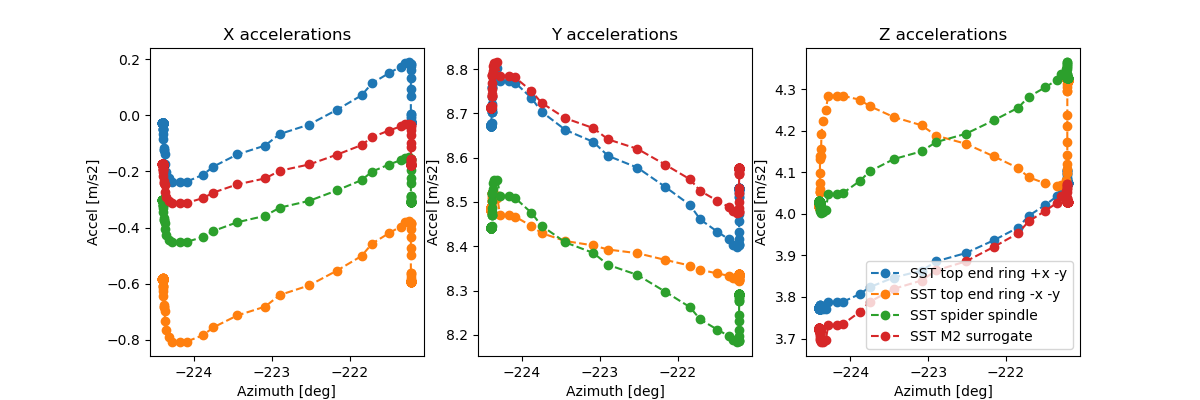

In [422]:
fig, ax = plt.subplots(nrows = 1,ncols = 3, figsize = (12,4))

#plt.suptitle(f"Accelerometer accelerations vs Azimuth")

for i, baseField in enumerate(baseFields):
    for col in az_df:
        if (baseField[-1]) in col:
            plt.subplot(1,3,i+1)
            plt.title(f'{baseField[-1]} accelerations')
            plt.plot(az_df['actualPosition'], az_df[col], linestyle='--', marker='o', label=f'{sensorNames[int(col[-1])]}')
            elticks = el_df['actualPosition']
            # ax2 = ax.secondary_xaxis('top')
            # ax2.tick_params(axis='x', color='red')
            # ax2.set_xticks(elticks, minor=False)
            plt.ylabel("Accel [m/s2]")
            plt.xlabel("Azimuth [deg]")

plt.legend(loc='lower right')
#, bbox_to_anchor=(0.2, 0.2))

## Timeline: Az velocity with Accelerometers X, Y and Z 

In [125]:
yr_cen=np.median(az['actualVelocity'])
dy=1.1*(np.max(az['actualVelocity'])- np.min(az['actualVelocity']))

p = figure(x_axis_type='datetime', y_range=(yr_cen-dy, yr_cen+dy), plot_width=1200, plot_height=800)
p.yaxis.axis_label = "Velocity [deg/s]"
p.xaxis.axis_label = "Time"
p.title = "AZ Velocity and Accelerometer X,Y and Z (m/s2) \n"

# AZ velocity
p.line(x=(Time(az.index.values)).value, 
        y=az['actualVelocity'], 
        color='blue', alpha=0.5, 
        legend_label='MTMount Measured Az Velocity')


# Accelerometers
p.extra_y_ranges = {'Accelerometers': Range1d(start=-3, end=12)}
p.add_layout(LinearAxis(y_range_name='Accelerometers', axis_label='Accel [m/s^2]'), 'right')

for i, sensorName in enumerate(sensorNames):
    sub_dataframe = packed_dataframe.loc[packed_dataframe.sensorName==sensorName]
    for baseField in baseFields:
        df = merge_packed_time_series(sub_dataframe, baseField, stride=1,
                             ref_timestamp_col="timestamp", fmt='unix_tai',
                             scale='tai')
        p.line(x=(Time(df.index.values)).value, 
               y=df[baseField], 
               color=colours[i], alpha=0.5, 
               y_range_name = 'Accelerometers',
               legend_label=f"{list(baseField[-1])} {sensorName}")


#p.legend.location = 'bottom_left'
p.legend.click_policy = 'hide'
show_in_pos(azPos)
#show_track_command(az_track)

show(p)



## Timeline: EL velocity timeline with Accelerometers X, Y and Z 

In [123]:
yr_cen=np.median(el['actualVelocity'])
dy=1.1*(np.max(el['actualVelocity'])- np.min(el['actualVelocity']))

p = figure(x_axis_type='datetime', y_range=(yr_cen-dy, yr_cen+dy), plot_width=1200, plot_height=800)
p.yaxis.axis_label = "Velocity [deg/s]"
p.xaxis.axis_label = "Time"
p.title = "EL Velocity and Accelerometers X,Y and Z (m/s2) \n"

# AZ velocity
p.line(x=(Time(el.index.values)).value, 
        y=el['actualVelocity'], 
        color='blue', alpha=0.5, 
        legend_label='MTMount Measured EL Velocity')


# Accelerometers
p.extra_y_ranges = {'Accelerometers': Range1d(start=-3, end=12)}
p.add_layout(LinearAxis(y_range_name='Accelerometers', axis_label='Accel [m/s^2]'), 'right')

for i, sensorName in enumerate(sensorNames):
    sub_dataframe = packed_dataframe.loc[packed_dataframe.sensorName==sensorName]
    for baseField in baseFields:
        df = merge_packed_time_series(sub_dataframe, baseField, stride=1,
                             ref_timestamp_col="timestamp", fmt='unix_tai',
                             scale='tai')
        p.line(x=(Time(df.index.values)).value, 
               y=df[baseField], 
               color=colours[i], alpha=0.5, 
               y_range_name = 'Accelerometers',
               legend_label=f"{list(baseField[-1])} {sensorName}")

#p.legend.location = 'bottom_left'
p.legend.click_policy = 'hide'
show_in_pos(elPos)

show(p)



## Correlation matrix

### Time Domain

/tmp/ipykernel_10300/2553184137.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))


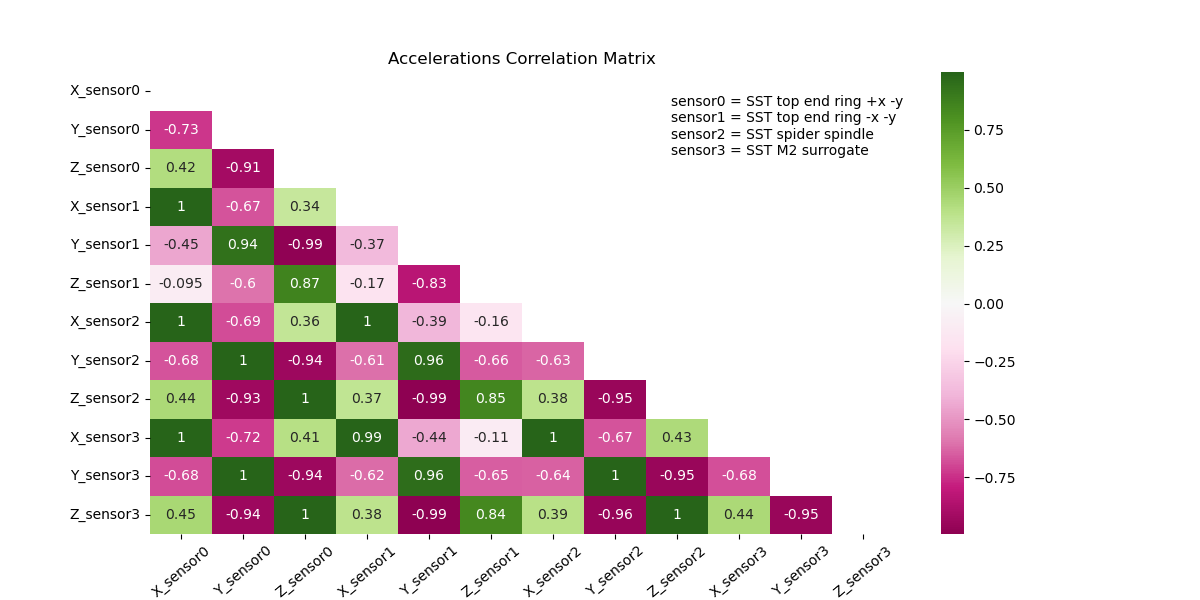

In [439]:
import seaborn as sn

plt.figure(figsize=(12, 6))
corr_matrix = accel_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
#heatmap = sn.heatmap(corr_matrix, annot=True, mask = mask, cmap="PiYG")
ax = sn.heatmap(corr_matrix, annot=True, mask = mask, cmap="PiYG")
plt.xticks(rotation=40)
plt.title("Accelerations Correlation Matrix")
conversion_text = ("\n".join(f"sensor{i} = {sensorNames[i]}" for i in range(4)))
plt.text(0.7, 0.95, conversion_text , transform=ax.transAxes, fontsize=10,
        verticalalignment='top')
plt.show()

### Frequency domanin

In [322]:
# Build data frame with FFT for each accelerometer sensor and channel
fft_df = pd.DataFrame()
for column in accel_df:
    col = accel_df[column]

    frate = 1.0 / 200.0
    
    Pfft = np.fft.fft(col)
    N = len(Pfft)
    
    freqs = np.fft.fftfreq(len(Pfft), frate)
    
    fft_df[f'{column}_freq'] = freqs
    fft_df[f'{column}_Pfft'] = Pfft

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


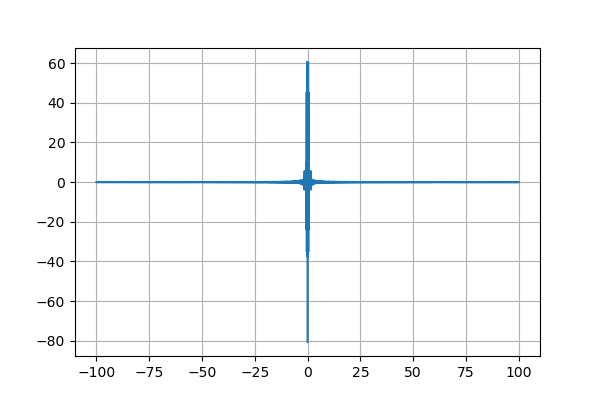

In [324]:
plt.figure(figsize=(6,4))
frate = 1. / 200
Pfft = np.fft.fft(accel_df['X_sensor0'])
N = len(Pfft)
# Pfft[0] = 0  # Set huge DC component to zero, equates to Pressure = Pressure - numpy.mean(Pressure)

freqs = np.fft.fftfreq(len(Pfft), frate)
#freqs2 = np.fft.fftfreq(len(Pfft), 1. / frate)

plt.plot(freqs, Pfft)

plt.grid()

plt.show()

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/pandas/core/internals/managers.py:1794: ComplexWarning: Casting complex values to real discards the imaginary part
  result[rl.indexer] = arr
/tmp/ipykernel_10300/3281762769.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))


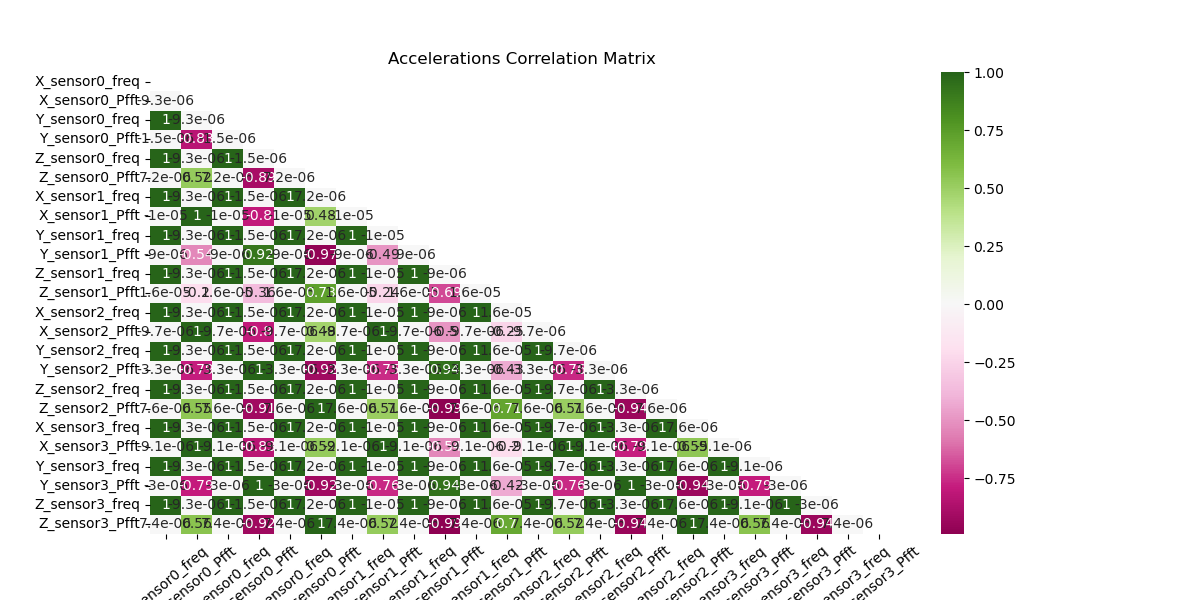

In [307]:
plt.figure(figsize=(12, 6))
corr_matrix = fft_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
ax = sn.heatmap(corr_matrix, annot=True, mask = mask, cmap="PiYG")
plt.xticks(rotation=40)
plt.title("Accelerations Correlation Matrix")
plt.show()